In [129]:
import pandas as pd
import numpy as np
import FinanceDataReader as fdr
import yfinance as yf
pd.set_option('max_rows',20)
pd.set_option('max_columns',100)

### get data


#### kospi

In [2]:
kospiBefore1998 = fdr.DataReader('KS11', start='1980', end='1998')
kospiBefore1998 = kospiBefore1998#.reset_index()

kospiAfter1998 = fdr.DataReader('KS11', start='1997', end='2017')
kospiAfter1998 = kospiAfter1998#.reset_index()

kospiAfter2016 = fdr.DataReader('KS11', start='2016', end=None)
kospiAfter2016 = kospiAfter2016#.reset_index()

In [3]:
_ = pd.concat([kospiBefore1998, kospiAfter1998])
kospi = pd.concat([_, kospiAfter2016])

In [4]:
kospi = kospi.drop_duplicates()

In [5]:
kospi['overNightChange'] = kospi['Open'].shift(-1) / kospi['Close'] - 1

In [6]:
kospi = kospi.reset_index()

In [7]:
kospiFirstDate = str(kospi['Date'].iloc[0])

In [8]:
kospi

,Date,Close,Open,High,Low,Volume,Change,overNightChange
0,1981-05-01,123.60,123.60,123.60,123.60,3330000.0,0.0098,-0.000809
1,1981-05-02,123.50,123.50,123.50,123.50,2040000.0,-0.0008,-0.023482
2,1981-05-04,120.60,120.60,120.60,120.60,1930000.0,-0.0235,0.000829
3,1981-05-06,120.70,120.70,120.70,120.70,1690000.0,0.0008,-0.011599
4,1981-05-07,119.30,119.30,119.30,119.30,1480000.0,-0.0116,-0.005029
...,...,...,...,...,...,...,...,...
10324,2019-11-04,2130.24,2111.32,2130.83,2111.32,476260000.0,0.0143,0.001605
10325,2019-11-05,2142.64,2133.66,2143.12,2128.70,400640000.0,0.0058,0.000023
10326,2019-11-06,2144.15,2142.69,2156.23,2138.83,410080000.0,0.0007,-0.001446
10327,2019-11-07,2144.29,2141.05,2147.01,2135.45,417910.0,0.0001,0.004612


#### snp500

In [9]:
snp = yf.Ticker("^GSPC")
snp = snp.history(period="max")

In [10]:
snp = snp.shift(1)

In [11]:
snp = snp[snp.index >= kospiFirstDate]

In [12]:
snp = snp.reset_index()

In [13]:
snp = snp[snp.columns[:-2]]

In [14]:
# snp['Change'] = snp['Close'].shift(1) / snp['Close'].shift(0) - 1

In [15]:
snp['Change'] = (snp['Close'].shift(0) - snp['Close'].shift(1)) / snp['Close'].shift(1)

In [82]:
snp

,Date,Open,High,Low,Close,Volume,Change
0,1981-05-01,133.050003,134.440002,131.850006,132.809998,4.797000e+07,NaN
1,1981-05-04,132.809998,134.169998,131.429993,132.720001,4.836000e+07,-0.000678
2,1981-05-05,131.779999,131.779999,129.610001,130.669998,4.043000e+07,-0.015446
...,...,...,...,...,...,...,...
9712,2019-11-05,3078.959961,3085.199951,3074.870117,3078.270020,4.146850e+09,0.003704
9713,2019-11-06,3080.800049,3083.949951,3072.149902,3074.620117,4.486130e+09,-0.001186
9714,2019-11-07,3075.100098,3078.340088,3065.889893,3076.780029,4.458190e+09,0.000702


#### krw/usd

### wrangle

#### left merge

In [16]:
dates = pd.concat([snp['Date'], kospi['Date']])

In [17]:
dates = dates.drop_duplicates()

In [18]:
dates = dates.sort_values()

In [19]:
dates = dates.reset_index(drop=True)

In [20]:
df = pd.DataFrame([])

In [21]:
df['Date'] = dates

In [22]:
df = df.merge(kospi, how='left')

In [23]:
df = pd.merge(left=snp, right=df, on='Date', suffixes=['_snp','_kospi'])

#### missing value process

In [24]:
df = df.fillna(method='ffill')
df = df.fillna(method='bfill')

#### more columns

In [25]:
df['Range_snp'] = _ =(df['Close_snp'] - df['Open_snp']) / (df['High_snp'] - df['Low_snp'])

In [26]:
df['Close/Open_snp'] = df['Close_snp'] / df['Open_snp'] - 1

In [27]:
df['High/Low_snp'] = df['High_snp'] / df['Low_snp'] - 1

In [28]:
df['rolling(5)_snp'] = df['Close_snp'].rolling(5).mean()

In [29]:
df['rolling(10)_snp'] = df['Close_snp'].rolling(10).mean()

In [30]:
df['rolling(20)_snp'] = df['Close_snp'].rolling(20).mean()

In [31]:
df['rolling(60)_snp'] = df['Close_snp'].rolling(60).mean()

In [32]:
df['Disparity(5)_snp'] = df['Close_snp'] / df['rolling(5)_snp']

In [33]:
df['Disparity(10)_snp'] = df['Close_snp'] / df['rolling(10)_snp']

In [34]:
df['Disparity(20)_snp'] = df['Close_snp'] / df['rolling(20)_snp']

In [35]:
df['Disparity(60)_snp'] = df['Close_snp'] / df['rolling(60)_snp']

In [36]:
df = df.fillna(method='ffill')
df = df.fillna(method='bfill')

### modeling

In [120]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix
from catboost import CatBoostClassifier
from catboost import CatBoostRegressor

In [90]:
df['overNightChangeBinary'] = df['overNightChange'].apply(lambda x: 1 if x >= 0 else 0)
df['Change_kospiBinary'] = df['Change_kospi'].apply(lambda x: 1 if x >= 0 else 0)

In [91]:
testSetRatio = 0.1
cuttingPoint = int(len(df) * (1-testSetRatio))

In [92]:
dfTest = df.iloc[cuttingPoint:,:]
dfTrainValid = df.iloc[:cuttingPoint,:]

In [93]:
features = [i for i in list(df.columns) if 'snp' in i]

In [94]:
df

,Date,Open_snp,High_snp,Low_snp,Close_snp,Volume_snp,Change_snp,Close_kospi,Open_kospi,High_kospi,Low_kospi,Volume_kospi,Change_kospi,overNightChange,Range_snp,Close/Open_snp,High/Low_snp,rolling(5)_snp,rolling(10)_snp,rolling(20)_snp,rolling(60)_snp,Disparity(5)_snp,Disparity(10)_snp,Disparity(20)_snp,Disparity(60)_snp,overNightChangeBinary,Change_kospiBinary
0,1981-05-01,133.050003,134.440002,131.850006,132.809998,4.797000e+07,-0.000678,123.60,123.60,123.60,123.60,3330000.0,0.0098,-0.000809,-0.092666,-0.001804,0.019644,131.460001,131.161002,131.738000,131.152334,0.994827,0.995342,1.012995,0.979472,0,1
1,1981-05-04,132.809998,134.169998,131.429993,132.720001,4.836000e+07,-0.000678,120.60,120.60,120.60,120.60,1930000.0,-0.0235,0.000829,-0.032845,-0.000678,0.020848,131.460001,131.161002,131.738000,131.152334,0.994827,0.995342,1.012995,0.979472,1,0
2,1981-05-05,131.779999,131.779999,129.610001,130.669998,4.043000e+07,-0.015446,120.60,120.60,120.60,120.60,1930000.0,-0.0235,0.000829,-0.511521,-0.008423,0.016743,131.460001,131.161002,131.738000,131.152334,0.994827,0.995342,1.012995,0.979472,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9712,2019-11-05,3078.959961,3085.199951,3074.870117,3078.270020,4.146850e+09,0.003704,2142.64,2133.66,2143.12,2128.70,400640000.0,0.0058,0.000023,-0.066791,-0.000224,0.003359,3053.279980,3033.916992,3000.120972,2961.098324,1.008185,1.014619,1.026049,1.039570,1,1
9713,2019-11-06,3080.800049,3083.949951,3072.149902,3074.620117,4.486130e+09,-0.001186,2144.15,2142.69,2156.23,2138.83,410080000.0,0.0007,-0.001446,-0.523721,-0.002006,0.003841,3060.826025,3041.780005,3009.198975,2964.296993,1.004507,1.010796,1.021740,1.037217,0,1
9714,2019-11-07,3075.100098,3078.340088,3065.889893,3076.780029,4.458190e+09,0.000702,2144.29,2141.05,2147.01,2135.45,417910.0,0.0001,0.004612,0.134932,0.000546,0.004061,3066.828027,3049.006006,3017.067981,2966.804659,1.003245,1.009109,1.019791,1.037069,1,1


#### targetColumn = overNightChange

In [95]:
targetColumn = 'overNightChangeBinary'

In [96]:
trainX, validX, trainy, validy = train_test_split(dfTrainValid[features], dfTrainValid[targetColumn], test_size=0.3)

In [97]:
model = CatBoostClassifier(iterations=500, learning_rate=0.1,
                            eval_metric='AUC', # [ RMSE , R2 ]
                            loss_function='CrossEntropy',
                            use_best_model=True,
                            max_depth=4,
                            #depth=6,
                            bagging_temperature = 0.2,
                            metric_period = 25)

In [98]:
model.fit(
    trainX, trainy,
    # cat_features=categorical_features_indices,
    verbose=True,
    plot=True, # NOTE: does not work for classifier
    eval_set=(validX, validy)
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.5402487	best: 0.5402487 (0)	total: 19.9ms	remaining: 9.94s
25:	test: 0.5516017	best: 0.5516017 (25)	total: 354ms	remaining: 6.45s
50:	test: 0.5550572	best: 0.5550572 (50)	total: 673ms	remaining: 5.93s
75:	test: 0.5518473	best: 0.5550572 (50)	total: 830ms	remaining: 4.63s
100:	test: 0.5480515	best: 0.5550572 (50)	total: 982ms	remaining: 3.88s
125:	test: 0.5492998	best: 0.5550572 (50)	total: 1.17s	remaining: 3.48s
150:	test: 0.5524501	best: 0.5550572 (50)	total: 1.42s	remaining: 3.28s
175:	test: 0.5520502	best: 0.5550572 (50)	total: 1.62s	remaining: 2.98s
200:	test: 0.5525594	best: 0.5550572 (50)	total: 1.91s	remaining: 2.84s
225:	test: 0.5531155	best: 0.5550572 (50)	total: 2.1s	remaining: 2.55s
250:	test: 0.5519753	best: 0.5550572 (50)	total: 2.27s	remaining: 2.26s
275:	test: 0.5512936	best: 0.5550572 (50)	total: 2.5s	remaining: 2.03s
300:	test: 0.5529424	best: 0.5550572 (50)	total: 2.65s	remaining: 1.75s
325:	test: 0.5520017	best: 0.5550572 (50)	total: 2.8s	remaining: 1.49s


In [99]:
predicted = model.predict(dfTest[features])

In [59]:
print('accuracy is')
sum(predicted == dfTest[targetColumn]) / len(predicted)

accuracy is


0.5596707818930041

#### targetColumn = kospi Change

In [107]:
targetColumn = 'Change_kospiBinary'

In [108]:
trainX, validX, trainy, validy = train_test_split(dfTrainValid[features], dfTrainValid[targetColumn], test_size=0.3)

In [109]:
model = CatBoostClassifier(iterations=500,
                           learning_rate=0.1,
                            eval_metric='AUC', # [ RMSE , R2 ]
                            loss_function='CrossEntropy',
                            use_best_model=True,
                            max_depth=6,
                            #depth=6,
                            bagging_temperature = 0.2,
                            metric_period = 25)

In [110]:
model.fit(
    trainX, trainy,
    # cat_features=categorical_features_indices,
    verbose=True,
    plot=True, # NOTE: does not work for classifier
    eval_set=(validX, validy)
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.5913169	best: 0.5913169 (0)	total: 23.4ms	remaining: 11.7s
25:	test: 0.6065192	best: 0.6065192 (25)	total: 454ms	remaining: 8.27s
50:	test: 0.6057367	best: 0.6065192 (25)	total: 707ms	remaining: 6.22s
75:	test: 0.6030292	best: 0.6065192 (25)	total: 871ms	remaining: 4.86s
100:	test: 0.5977424	best: 0.6065192 (25)	total: 1.12s	remaining: 4.43s
125:	test: 0.5950215	best: 0.6065192 (25)	total: 1.29s	remaining: 3.84s
150:	test: 0.5888576	best: 0.6065192 (25)	total: 1.47s	remaining: 3.39s
175:	test: 0.5854385	best: 0.6065192 (25)	total: 1.65s	remaining: 3.03s
200:	test: 0.5837380	best: 0.6065192 (25)	total: 1.86s	remaining: 2.77s
225:	test: 0.5820264	best: 0.6065192 (25)	total: 2.05s	remaining: 2.48s
250:	test: 0.5769050	best: 0.6065192 (25)	total: 2.24s	remaining: 2.22s
275:	test: 0.5737632	best: 0.6065192 (25)	total: 2.65s	remaining: 2.15s
300:	test: 0.5723452	best: 0.6065192 (25)	total: 2.86s	remaining: 1.89s
325:	test: 0.5697400	best: 0.6065192 (25)	total: 3.07s	remaining: 1.6

In [133]:
_ = pd.DataFrame(model.feature_importances_)
_.index = features
_.columns=['featureImportance']

In [134]:
_

,featureImportance
Open_snp,0.598990
High_snp,2.517800
Low_snp,5.560289
Close_snp,3.235270
Volume_snp,8.251741
Change_snp,8.627995
Range_snp,12.028348
Close/Open_snp,9.733452
High/Low_snp,6.004050
rolling(5)_snp,3.041959


In [125]:
model.feature_importances_

array([ 0.59898977,  2.51780028,  5.56028907,  3.23526977,  8.25174061,
        8.62799549, 12.02834759,  9.73345198,  6.00405011,  3.04195908,
        2.82536728,  3.96850575,  3.75437129, 11.08337339,  6.96002858,
        6.99576647,  4.81269349])

In [111]:
predicted = model.predict(dfTest[features])

In [116]:
tn, fp, fn, tp = confusion_matrix(predicted, dfTest[targetColumn]).ravel() / len(dfTest)

In [118]:
confusion_matrix(predicted, dfTest[targetColumn]).ravel() / len(dfTest)

array([0.22736626, 0.1718107 , 0.22119342, 0.37962963])

In [117]:
confusion_matrix(predicted, dfTest[targetColumn]) / len(dfTest)

array([[0.22736626, 0.1718107 ],
       [0.22119342, 0.37962963]])

In [113]:
print('accuracy is')
sum(predicted == dfTest[targetColumn]) / len(predicted)

accuracy is


0.6069958847736625

### result

In [66]:
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.tree import DecisionTreeClassifier
def jitt(arr):
    stdev = .01*(max(arr)-min(arr))
    return arr + np.random.randn(len(arr)) * stdev

In [67]:
dfTestPredicted = dfTest.copy()

In [68]:
dfTestPredicted['predicted'] = model.predict(dfTestPredicted[features]).astype(int)

In [69]:
dfTestPredicted['predictedProbaToBeOne'] = np.array([i[1] for i in model.predict_proba(dfTestPredicted[features])])

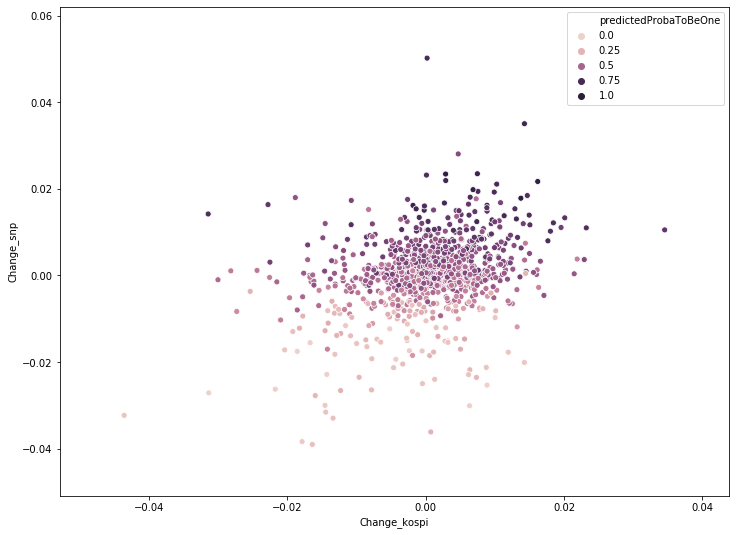

In [70]:
plt.figure(figsize=(12, 9))
sns.scatterplot(x=jitt(dfTestPredicted['Change_kospi']),
                y=jitt(dfTestPredicted['Change_snp']),
                hue=dfTestPredicted['predictedProbaToBeOne'])

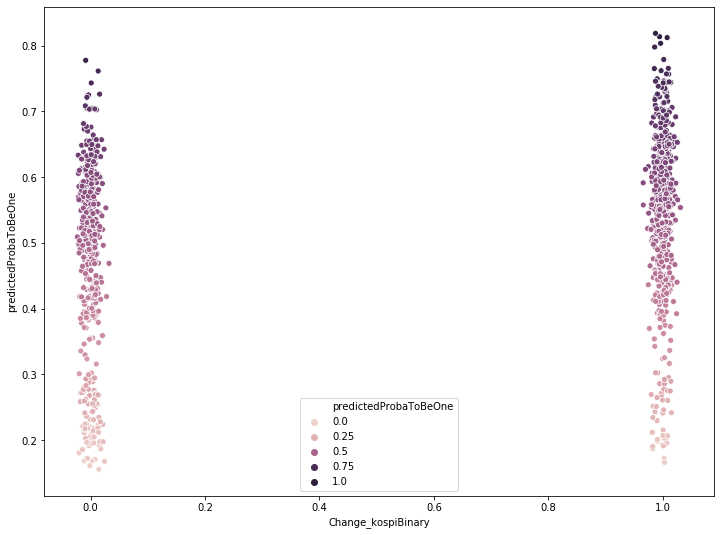

In [71]:
plt.figure(figsize=(12, 9))
sns.scatterplot(x=jitt(dfTestPredicted['Change_kospiBinary']),
                y=jitt(dfTestPredicted['predictedProbaToBeOne']),
               hue=jitt(dfTestPredicted['predictedProbaToBeOne'])
               )

#### tree on prediction

In [136]:
dfTestPredicted['isRight'] = dfTestPredicted['predicted'] == dfTestPredicted['Change_kospiBinary']

In [137]:
targetColumn = 'isRight'

In [138]:
dtc = DecisionTreeClassifier(min_samples_split=30, 
                            max_depth=4, 
                            min_samples_leaf=10)

In [139]:
dtc.fit(dfTestPredicted[features], dfTestPredicted[targetColumn])

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=30,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

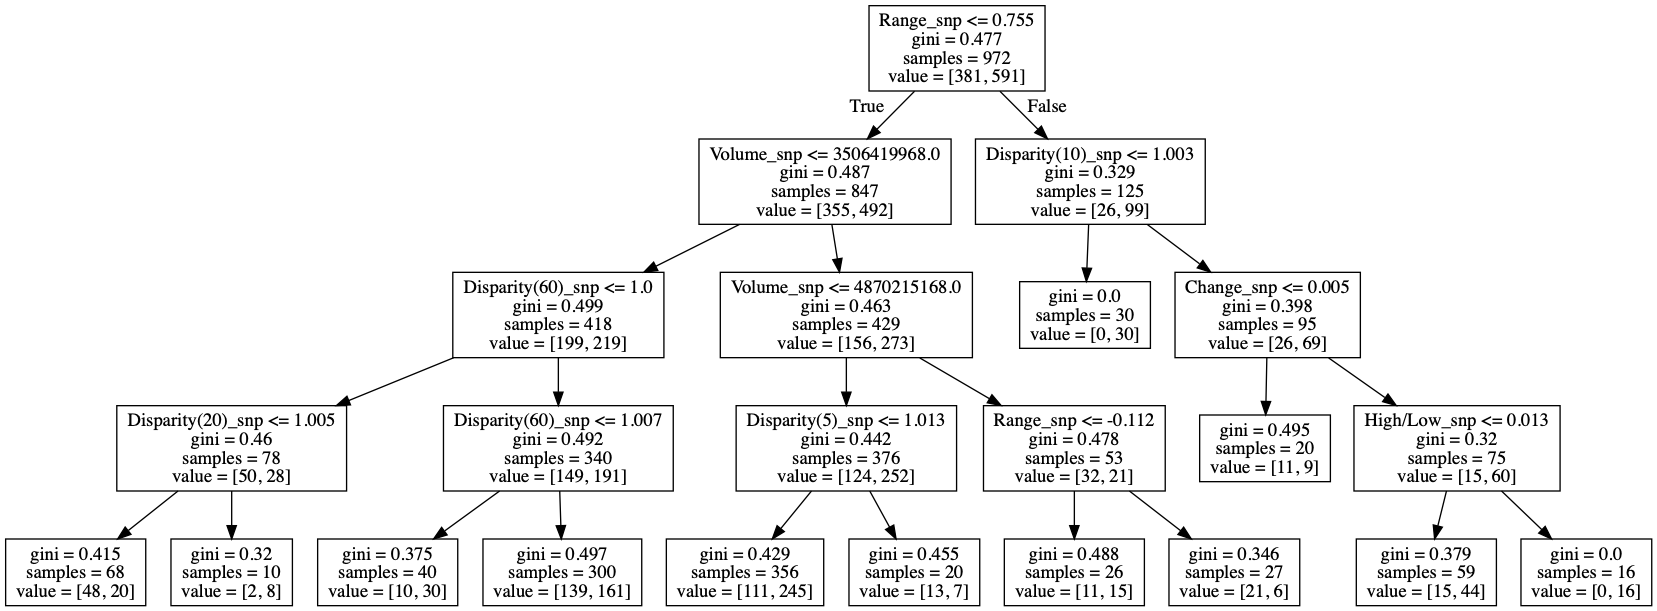

In [140]:
from IPython.display import Image  
import pydotplus
import graphviz
from sklearn import tree

dot_data = tree.export_graphviz(dtc, out_file=None, feature_names=features)

# Draw graph
graph = pydotplus.graph_from_dot_data(dot_data)  

# Show graph
Image(graph.create_png())